In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn import metrics, linear_model
from math import ceil

In [3]:
ls data/

binMNIST.mat*        bindigit_tst.csv*    targetdigit_tst.csv*
bindigit_trn.csv*    targetdigit_trn.csv*


In [4]:
bin_train = np.genfromtxt('data/bindigit_trn.csv',delimiter=',',)
target_train = np.genfromtxt('data/targetdigit_trn.csv',delimiter=',',)
bin_test = np.genfromtxt('data/bindigit_tst.csv',delimiter=',',)
target_test = np.genfromtxt('data/targetdigit_tst.csv',delimiter=',',)

# RBM

In [5]:
class RBM(BernoulliRBM):
    def reconstruct(self, X):
        inner = np.dot(np.dot(self.components_.T, self.components_),X.T).T
        recon = inner / inner.max(axis=0)
        return recon
    

In [6]:
def calculate_error(data, recon_data):
    return np.average(np.absolute(data-recon_data))

In [16]:
def report_RBM(hidden_dim, learning_rate, batch_size = 64, iterations = 10):
    
    rbm = RBM(n_components = hidden_dim, batch_size = batch_size, learning_rate = learning_rate,
                  n_iter = iterations, verbose = False, random_state = 0)
    errors = []
    for i in range(iterations):
        rbm.n_iter = i
        rbm.fit(bin_train)
        recon = rbm.reconstruct(bin_test)
        errors.append(calculate_error(bin_test, recon))
        print("finished iteration #{}".format(i+1))
    plt.plot(errors)
    plt.title("Test error per iteration, {} hidden nodes, {} learning rate".format(hidden_dim, learning_rate))
    plt.show()
    plt.figure(figsize = (20,10))
    for j in range(1,10):
        index = np.where(target_test==j)[0][0]
        
        # Plot original
        plt.subplot(10, 2, j*2-1)
        plt.imshow(bin_test[index,:].reshape((28, 28)), cmap=plt.cm.gray_r,
           interpolation='nearest')
        plt.gray()
        plt.xticks(())
        plt.yticks(())
        
        plt.subplot(10, 2, j*2)
        #Plot reconstruction
        plt.imshow(rbm.reconstruct(bin_test[index,:]).reshape((28, 28)), cmap=plt.cm.gray_r,
           interpolation='nearest')
        plt.gray()
        plt.xticks(())
        plt.yticks(())
    plt.suptitle("original vs reconstruction".format(j))
    plt.subplots_adjust(left = 0.125, right = 0.175, wspace = 0, hspace = 0)
    
    plt.figure(figsize=(10.2, 10))
    for i, comp in enumerate(rbm.components_):
        plt.subplot(10, ceil(hidden_dim/10), i + 1)
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.gray()
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('{} components extracted by RBM'.format(hidden_dim), fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

finished loop #1
finished loop #2
finished loop #3
finished loop #4
finished loop #5
finished loop #6
finished loop #7
finished loop #8
finished loop #9
finished loop #10


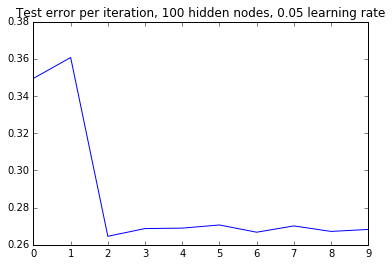

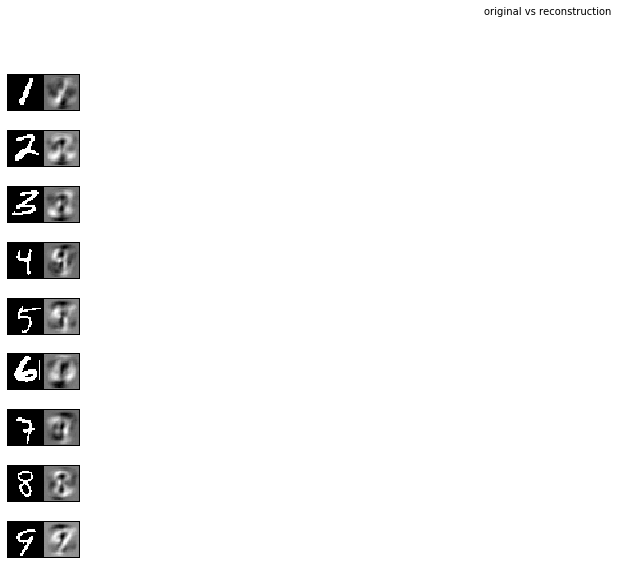

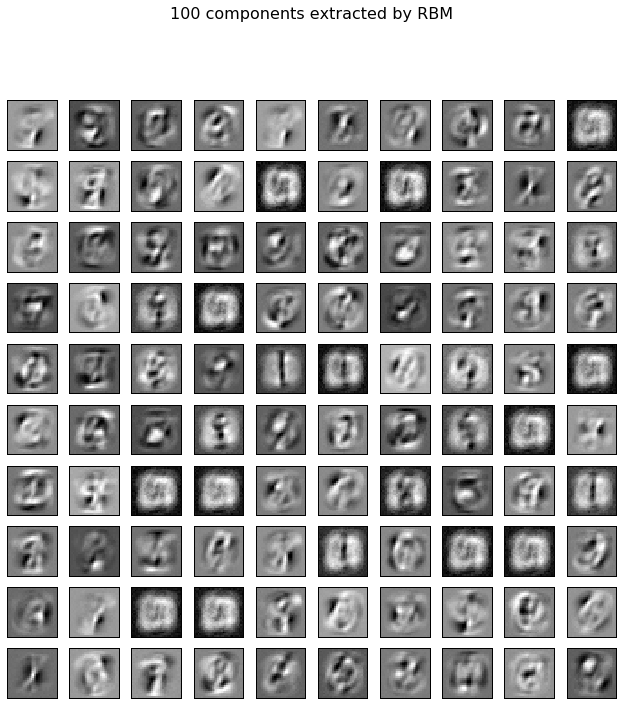

In [15]:
recon = report_RBM(hidden_dim = 100, learning_rate = 0.05)

# Autoenconder

In [17]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [18]:
def report_autoenconder(hidden_dim, epochs = 50, batch_size = 64):
    input_img = Input(shape=(784,))
    
    encoded = Dense(hidden_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    encoder.compile(optimizer='adadelta', loss='mean_squared_error')
    
    result = autoencoder.fit(bin_train, bin_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(bin_test, bin_test))
    
    #Plot learning rates
    loss = result.history['loss']
    valLoss = result.history['val_loss']
    plt.plot(range(len(loss)),loss,label='MSE training')
    plt.plot(range(len(valLoss)),valLoss,label='MSE test')
    plt.title('MSE over iterations, {} hidden nodes'.format(hidden_dim))
    plt.legend()
    plt.show()

    #Plot images and reconstruction
    prediction = autoencoder.predict(bin_test)
    plt.figure(figsize = (20,10))
    for j in range(1,10):
        index = np.where(target_test==j)[0][0]
        
        # Plot original
        plt.subplot(10, 2, j*2-1)
        plt.imshow(bin_test[index,:].reshape((28, 28)), cmap=plt.cm.gray_r,
           interpolation='nearest')
        plt.gray()
        plt.xticks(())
        plt.yticks(())
        
        plt.subplot(10, 2, j*2)
        #Plot reconstruction
        plt.imshow(prediction[index,:].reshape((28, 28)), cmap=plt.cm.gray_r,
           interpolation='nearest')
        plt.gray()
        plt.xticks(())
        plt.yticks(())
    plt.suptitle("original vs prediction".format(j))
    plt.subplots_adjust(left = 0.125, right = 0.175, wspace = 0, hspace = 0)
    
    #Plot Autoencoder weights
    weights = autoencoder.get_weights()[0].T
    size = weights.shape[0]
    plt.figure(figsize=(10.2, 10))
    for i in range(size):
        ax = plt.subplot(10, ceil(size/10), i + 1)
        plt.imshow(weights[i].reshape(28, 28),cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.gray()
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('{} components extracted by autoencoder'.format(hidden_dim), fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

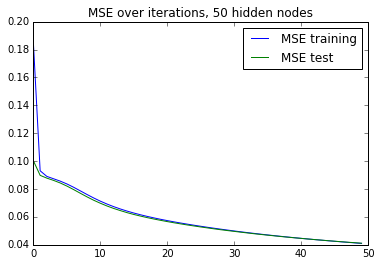

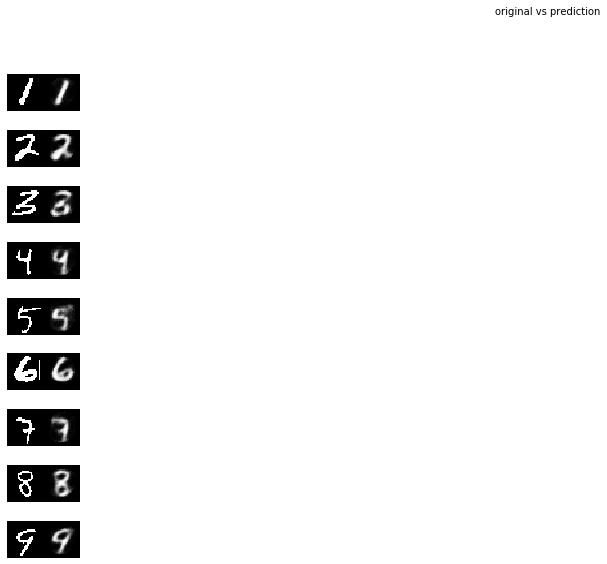

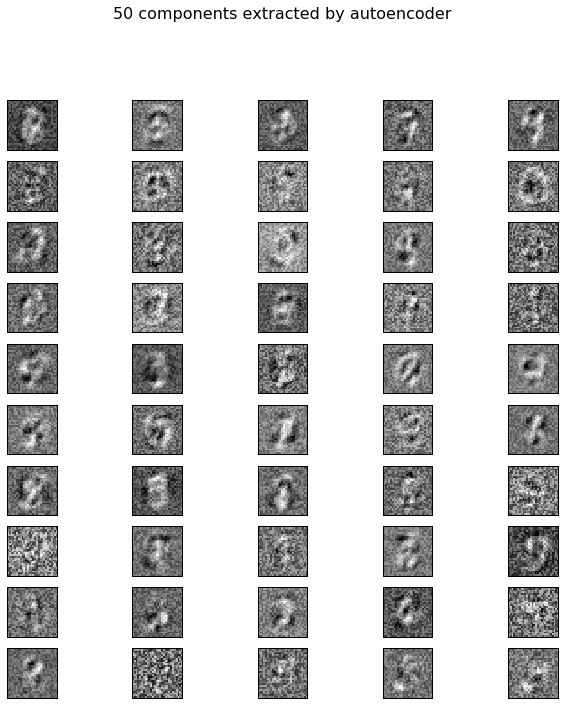

In [19]:
report_autoenconder(hidden_dim = 50)